In [1]:
import json
import os
import numpy as np

import src.Environments.BaseEnv as BaseEnv
import src.Utils.UserInputHelper as UI
from src.DataManager.DataManager import DataManager
from src.Utils.PathHelper import GetRootPath

import src.DataManager.DataColumnTypes as DCT
from src.Agents.Predictors import DecisonTreePredictor

In [2]:
configPath = os.path.join(GetRootPath(), "Config", "Envs")
envConfigPath = os.path.join(configPath, os.listdir(configPath)[2])
# load config
with open(envConfigPath) as f:
	config = json.load(f)

print(config)

{'Name': 'FrozenLake', 'EnvType': 'Gym', 'GymConfig': {'GymID': 'FrozenLake-v1', 'RenderMode': 'human', 'kwargs': {'is_slippery': False}}, 'IsDeterministic': False, 'MaxAgents': 1, 'MaxSteps': 50, 'MaxEpisodes': 1000, 'AgentConfig': {'Human': {'FPS': 10, 'Controls': {'left': 0, 'down': 1, 'right': 2, 'up': 3}}}}


In [3]:
# load env
env = BaseEnv.GetEnv(config)

path = os.path.join(GetRootPath(), "data", config["Name"])

# load data manager
dataManager = DataManager()
dataManager.Setup(config, env)
dataManager.Load(path)

print(f"replay buffer size: {len(dataManager._ReplayBuffer)}")

replay buffer size: 7600


In [4]:
# create predictor

xColumns = [DCT.DataColumnTypes.CurrentState, DCT.DataColumnTypes.Action]
yColumns = [DCT.DataColumnTypes.Terminated]

predictor = DecisonTreePredictor.DecisonTreePredictor(xColumns, yColumns)

In [5]:
x, y = predictor._GetSamples()

states = x[0]
actions = x[1]
x = np.array([np.array([states[i], actions[i]]) for i in range(len(states))])

y = np.array([int(i) for i in y[0]])
print(f"x: {x}")
print(f"y: {y}")

x: [[ 0  1]
 [ 4  3]
 [ 0  0]
 ...
 [14  2]
 [ 0  2]
 [ 1  1]]
y: [0 0 0 ... 1 0 1]


In [6]:
predictor.Train(x, y)

In [9]:
predictions = predictor.PredictValue(x)
print(f"predictions: {predictions}")

predictions: [0 0 0 ... 1 0 1]


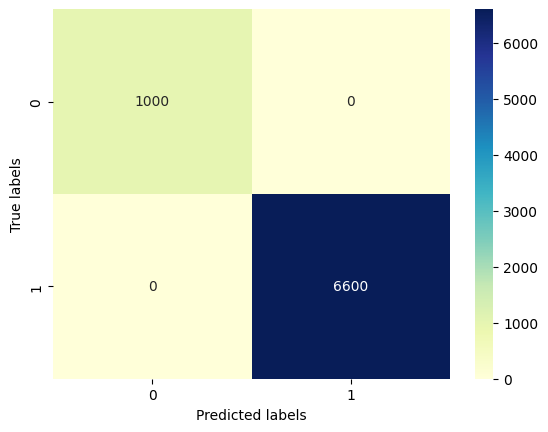

In [8]:


# create confusion matrix

def CreateConfusionMatrix(y, predictions):
	# true positive
	tp = np.sum(np.logical_and(predictions == 1, y == 1))
	# true negative
	tn = np.sum(np.logical_and(predictions == 0, y == 0))
	# false positive
	fp = np.sum(np.logical_and(predictions == 1, y == 0))
	# false negative
	fn = np.sum(np.logical_and(predictions == 0, y == 1))

	return tp, tn, fp, fn

# plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

def PlotConfusionMatrix(tp, tn, fp, fn):
	data = np.array([[tp, fp], [fn, tn]])
	ax = sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu")

	# labels, title and ticks
	ax.set_xlabel('Predicted labels')
	ax.set_ylabel('True labels')


	plt.show()
	return

tp, tn, fp, fn = CreateConfusionMatrix(y, predictions)
PlotConfusionMatrix(tp, tn, fp, fn)